In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from time import time

In [ ]:
nx = ny = 256 
dx = dy = 2.0e-08
dt = 5.0e-12 
stepmax = 7000 
pi = np.pi 
delta = 4.0 * dx # thickness of diffuse interface
gamma = 0.37 # interfacial energy [J/m2]
zeta = 0.03 # strength of anisotropy
aniso = 4.0 # mode of anisotropy
angle0 = 0.25*pi # growth angle
T_melt = 1728.0 # melting temperature [K]
K = 84.01 # thermal conductivity [W/(mK)]
c = 5.42e+06 # heat capacity [J/K]
latent = 2.35e+09 # latent heat [J/mol]
lamb = 0.1
b = 2.0 * np.arctanh(1.0-2.0*lamb)
mu = 2.0 # interfacial kinetic coefficient [m/(Ks)]
kappa = K / c # thermal diffusion coefficient
a0 = np.sqrt(3.0*delta*gamma/b) # gradient energy coefficient
www = 6.0 * gamma * b / delta # height of double-well potential
pmobi = b * T_melt * mu / (3.0 * delta * latent) # mobility of phase-field 
T_0 = 1424.5 # temperature [K]

In [ ]:
phi = np.zeros((nx,ny)) # phase-field at time t
phi_new = np.zeros((nx,ny)) # phase-field at time t+dt
temp = np.zeros((nx,ny)) # temperature at time t
temp_new = np.zeros((nx,ny)) # temperature at time t+dt
grad_phix = np.zeros((nx,ny)) # gradient of phase-field along x axis 
grad_phiy = np.zeros((nx,ny)) # gradient of phase-field along y axis
a2 = np.zeros((nx,ny)) # (gradient energy coefficient)^2
lap_temp = np.zeros((nx,ny)) # laplacian of temperature
lap_phi = np.zeros((nx,ny)) # laplacian of phase-field
ax = np.zeros((nx,ny)) 
ay = np.zeros((nx,ny))

In [ ]:
r0 = 3.*dx
for j in range(0,ny):
    for i in range(0,nx):
        phi[i,j] = 0.0
        x = dx*(i-nx/2)
        y = dy*(j-ny/2)
        r = np.sqrt(x*x + y*y)
        phi[i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*a0)*(r-r0)))
        if phi[i,j] <= 1.0e-5:
            phi[i,j] = 0.0
        temp[i,j] = T_0 + phi[i,j] * (T_melt-T_0)

In [ ]:
@jit(nopython=True)
def calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2):
    for j in range(ny):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx - 1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny - 1
            if jm < 0:
                jm = 0

            grad_phix[i,j] = (phi[ip,j]-phi[im,j])/(2.*dx)
            grad_phiy[i,j] = (phi[i,jp]-phi[i,jm])/(2.*dy)
            lap_phi[i,j] = (2.*(phi[ip,j]+phi[im,j]+phi[i,jp]+phi[i,jm])+phi[ip,jp]+phi[im,jm]+phi[im,jp]+phi[ip,jm]-12.*phi[i,j])/(3.*dx*dx)
            lap_temp[i,j]= (2.*(temp[ip,j]+temp[im,j]+temp[i,jp]+temp[i,jm])+temp[ip,jp]+temp[im,jm]+temp[im,jp]+temp[ip,jm]-12.*temp[i,j])/(3.*dx*dx)

            if grad_phix[i,j] == 0.:
                if grad_phiy[i,j] > 0.:
                    angle = 0.5*pi
                else:
                    angle = -0.5*pi
            elif grad_phix[i,j] > 0.:
                if grad_phiy[i,j] > 0.:
                    angle = np.arctan(grad_phiy[i,j]/grad_phix[i,j])
                else:
                    angle = 2.0*pi + np.arctan(grad_phiy[i,j]/grad_phix[i,j])
            else:
                angle = pi + np.arctan(grad_phiy[i,j]/grad_phix[i,j])

            a = a0*(1. + zeta * np.cos(aniso*(angle-angle0)))
            dadtheta = -a0*aniso*zeta*np.sin(aniso*(angle-angle0))
            ay[i,j] = -a * dadtheta * grad_phiy[i,j]
            ax[i,j] =  a * dadtheta * grad_phix[i,j]
            a2[i,j] = a * a

In [ ]:
@jit(nopython=True)
def timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2,phi_new,temp_new):
    for j in range(ny):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx - 1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny -1
            if jm < 0:
                jm = 0

            dxdy = (ay[ip,j]-ay[im,j])/(2.*dx)
            dydx = (ax[i,jp]-ax[i,jm])/(2.*dy)
            grad_a2x = (a2[ip,j]-a2[im,j])/(2.*dx)
            grad_a2y = (a2[i,jp]-a2[i,jm])/(2.*dy)
            tet = phi[i,j]
            drive = -latent * (temp[i,j]-T_melt) / T_melt
            scal = grad_a2x*grad_phix[i,j]+grad_a2y*grad_phiy[i,j]

            phi_new[i,j] = phi[i,j] + (dxdy + dydx + a2[i,j]*lap_phi[i,j] + scal + 4.0*www*tet*(1.0-tet)*(tet-0.5+15.0/(2.0*www)*drive*tet*(1.0-tet)))*dt*pmobi
            temp_new[i,j] = temp[i,j] + kappa*lap_temp[i,j]*dt + 30.0*tet*tet*(1.0-tet)*(1.0-tet)*(latent/c)*(phi_new[i,j]-tet)

It takes 119374.21441078186 ms


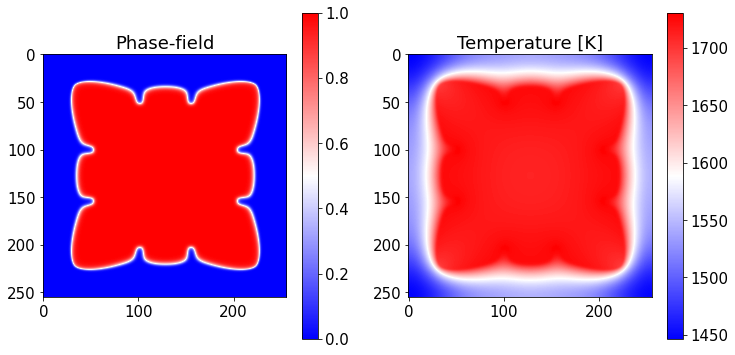

In [ ]:
start = time()
for nstep in range(stepmax):
    calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2)
    timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2,phi_new,temp_new)
    phi = phi_new
    temp = temp_new

end = time()
print("It takes", (end-start)*1000.0, "ms")

plt.figure(figsize=(12,6))
plt.rcParams["font.size"] = 15
plt.subplot(121)
plt.imshow(phi, cmap="bwr")
plt.title('Phase-field')
plt.colorbar()
plt.subplot(122)
plt.imshow(temp, cmap="bwr")
plt.title('Temperature [K]')
plt.colorbar()
plt.show()